In [1]:
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt

from arithmetic_lm.model import UniversalTransformer, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.formatting import format_line
from arithmetic_lm.constants import PLOTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
ckpt_path = "../checkpoints/addition-1-9-digit-pad/ut_1steps_384embd_2head/step=15500-train_loss=0.0108-val_loss=4.6606.ckpt"

In [3]:
tokenizer = CharTokenizer()

In [4]:
# load model
ckpt = torch.load(ckpt_path, map_location="mps")
model = UniversalTransformer(
    **ckpt["hyper_parameters"]["model_hparams"], vocab_size=tokenizer.vocab_size
)
# state dict has a prefix "model." in the key names
model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
model.eval()

UniversalTransformer(
  (embedding): Embedding(100, 384, padding_idx=99)
  (coord_encoder): CoordinateEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (linear1): Linear(in_features=384, out_features=1536, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1536, out_features=384, bias=True)
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): 

## Plot attention maps for 1 layer enc-dec

In [5]:
def predict_hooked(
    model: torch.nn.Module,
    prompt: torch.Tensor,
    decoder_prompt: torch.Tensor,
    hook_config: dict[str, dict[str, callable]],
) -> str:
    hooked_model = deepcopy(model)
    hooked_model.eval()

    for module_name, hook_dict in hook_config.items():
        module = eval(f"hooked_model.{module_name}", {"hooked_model": hooked_model})

        if pre_hook := hook_dict.get("pre_hook"):
            module.register_forward_pre_hook(pre_hook, with_kwargs=True)

        if hook := hook_dict.get("hook"):
            module.register_forward_hook(hook)

    logits = hooked_model(source=prompt, target=decoder_prompt)[0, -1, :]
    pred_token_id, pred_token_logit = logits.argmax().item(), logits.max().item()
    pred_token_str = tokenizer.decode([pred_token_id])

    # delete hooked model
    del hooked_model

    return pred_token_str, pred_token_logit

In [6]:
def get_attention_map(name: str, cache: dict):
    def hook(module, inputs, output):
        # nn.MultiheadAttention outputs 2 tensors by default:
        # - the output of the last linear transformation with shape [bs, tgt_len, embed_dim]
        # - the attention map (weights) with shape [bs, n_heads, tgt_len, src_len]
        cache[name] = output[1].detach()

    return hook


def set_attn_kwargs_prehook(module, args, kwargs):
    """
    make sure self.attn module is called with need_weights=True and
    average_attn_weights=False so that we get per-head attention weights
    """
    kwargs["need_weights"] = True
    kwargs["average_attn_weights"] = False
    return args, kwargs

In [20]:
# plot one head
def plot_head(
    ax: plt.Axes,
    map: torch.Tensor,
    title: str,
    cmap: str = "binary",
    xticks: list = None,
    yticks: list = None,
    colorbar: bool = True,
    alpha: float = 1.0,
):
    ax.imshow(map, cmap=cmap, interpolation="none", alpha=alpha)
    if yticks:
        ax.set_yticks(np.arange(len(yticks)) - 0.5)
        ax.set_yticklabels(yticks, va="top")
    if xticks:
        ax.set_xticks(np.arange(len(xticks)) - 0.5)
        ax.set_xticklabels(xticks, ha="left")
    ax.set_title(title)
    if colorbar:
        ax.figure.colorbar(ax.images[0], ax=ax, shrink=0.3)
    # grid
    ax.grid(which="both", color="k", linestyle=":", linewidth=0.5, alpha=0.5)
    ax.set_xlabel("source")
    ax.set_ylabel("target")


def plot_module(
    fig: plt.Figure,
    module_name: str,
    attn_map: torch.Tensor,
    enc_ticks,
    dec_ticks,
):
    n_heads = attn_map.shape[1]
    axs = fig.subplots(1, n_heads + 1)  # +1 for combined attn map
    fig.suptitle(module_name)
    src_len = attn_map.shape[-1]
    tgt_len = attn_map.shape[-2]

    # choose cmaps for combined attn map
    cmaps = ["Reds", "Blues", "Purples", "Greens", "Oranges"]

    for i in range(n_heads):
        plot_head(
            axs[i],
            attn_map[0, i],
            title=f"head {i}",
            xticks=enc_ticks if src_len == len(enc_ticks) else dec_ticks,
            yticks=enc_ticks if tgt_len == len(enc_ticks) else dec_ticks,
        )
        # combined attn map
        plot_head(
            axs[-1],
            attn_map[0, i],
            title="combined",
            cmap=cmaps[i % len(cmaps)],
            alpha=0.5,
            xticks=enc_ticks if src_len == len(enc_ticks) else dec_ticks,
            yticks=enc_ticks if tgt_len == len(enc_ticks) else dec_ticks,
            colorbar=False,
        )

In [84]:
def plot_attn_maps(
    a: int,
    b: int,
    pad_zeros: int,
    pad_ans_zeros: int,
    module_names: list[str],
    figname: str,
    decoding_step: int = None,
    save: bool = False,
):
    """
    decoding_step: how much to "forward" decoding process, i.e. pre-fill
        decoder prompt default: skip to first non-zero answer digit
    """
    prompt_str = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
    print("prompt:", repr(prompt_str))
    true_ans = a + b
    print("true_ans:", true_ans, f"padded: {str(true_ans).zfill(pad_ans_zeros)}")

    # "fast-forward" decoding by decoding_step steps
    decoder_prompt_str = "=" + str(true_ans).zfill(pad_ans_zeros)
    if not decoding_step:
        # skip to first non-zero answer digit
        decoding_step = len(decoder_prompt_str) - len(str(true_ans))
    true_next_token = decoder_prompt_str[decoding_step]
    decoder_prompt_str = decoder_prompt_str[:decoding_step]

    # just before first actual digit
    decoder_prompt = torch.tensor([tokenizer.encode(decoder_prompt_str)])
    print(f"decoder prompt: {decoder_prompt_str} (decoding step {decoding_step})")

    prompt = tokenizer.encode(prompt_str)
    prompt = torch.tensor([prompt])

    attn_maps = {}

    # get attention map from encoder_layer.self_attn
    pred_token_str, pred_token_logit = predict_hooked(
        model,
        prompt,
        decoder_prompt,
        hook_config={
            mn: {
                "hook": get_attention_map(mn, attn_maps),
                "pre_hook": set_attn_kwargs_prehook,
            }
            for mn in module_names
        },
    )

    print("pred_token_str:", pred_token_str)
    print("pred_token_logit:", pred_token_logit)
    for mn, matt in attn_maps.items():
        print(mn, matt.shape)

    # tokens for easier visualization
    enc_ticks = list(prompt_str)
    enc_ticks[0] = "\\n" if enc_ticks[0] == "\n" else enc_ticks[0]
    dec_ticks = list(decoder_prompt_str)

    # for each module, in a subfigure plot heads as subplots
    fig = plt.figure(layout="constrained", figsize=(10, 9))
    fig.suptitle(
        f"Attention maps for enc_prompt: {repr(prompt_str)}, dec_prompt: {repr(decoder_prompt_str)}"
        f"\n predicted token: {pred_token_str} ({'correct' if pred_token_str == true_next_token else 'incorrect, true: ' + true_next_token})",
    )

    subfigs = fig.subfigures(
        len(attn_maps), 1, hspace=0, wspace=0, height_ratios=[3, 2, 2]
    )
    for i, (module_name, attn_map) in enumerate(attn_maps.items()):
        plot_module(subfigs[i], module_name, attn_map, enc_ticks, dec_ticks)

    if save:
        plt.savefig(PLOTS_DIR / f"{figname}.png", dpi=90)
    plt.show()

In [85]:
pad_zeros = 10
pad_ans_zeros = 11
module_names = [
    "encoder_layer.self_attn",
    "decoder_layer.self_attn",
    "decoder_layer.multihead_attn",
]

prompt: '\n$0001111111+0000222222'
true_ans: 1333333 padded: 00001333333
decoder prompt: =0000 (decoding step 5)
pred_token_str: 1
pred_token_logit: 22.76961898803711
encoder_layer.self_attn torch.Size([1, 2, 23, 23])
decoder_layer.self_attn torch.Size([1, 2, 5, 5])
decoder_layer.multihead_attn torch.Size([1, 2, 5, 23])


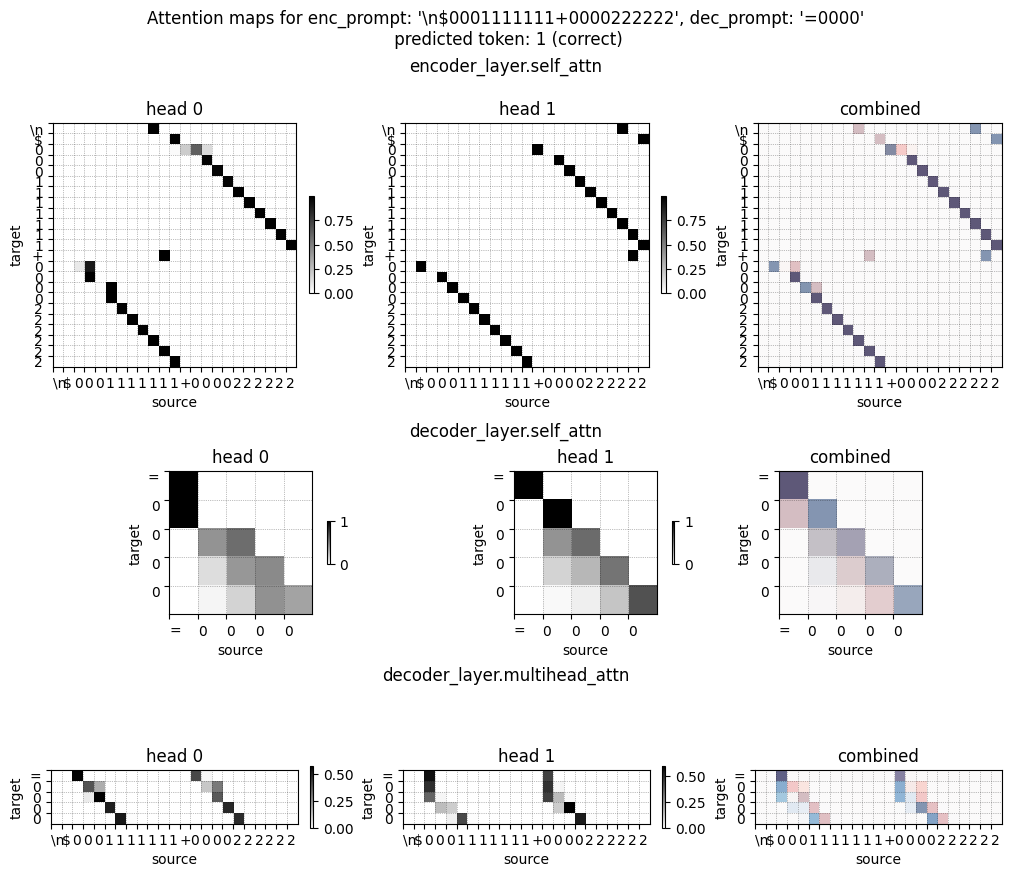

In [93]:
a, b = 1111111, 222222
decoding_step = 10
figname = f"exp8_attention_maps_{a}+{b}" + (
    f"_decoding_step_{decoding_step}" if decoding_step else ""
)
plot_attn_maps(
    a,
    b,
    pad_zeros,
    pad_ans_zeros,
    module_names,
    figname,
    # decoding_step=decoding_step,
    # save=True,
)